## DIFFUSION POSTERIOR SAMPLING FOR GENERAL NOISY INVERSE PROBLEMS
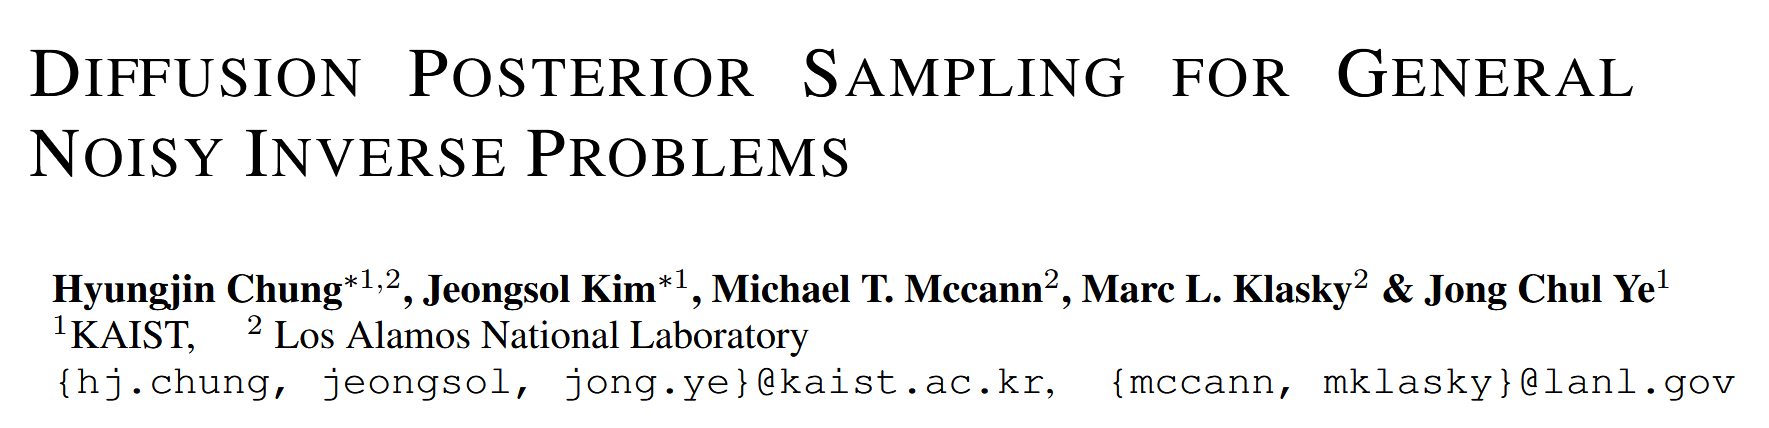
Published in International Conference on Learning Representations (ICLR), 2023  
Github Repo: https: //github.com/DPS2022/diffusion-posterior-sampling, 
Corresponding code: ../../../../code/Inv/diffusion-posterior-sampling-main/sample_condition.py

## 1. Highlights

Propose a guided diffusion sampling method tailored for solving general noisy inverse problems.

## 2. Background

Diffusion models (DMs) have recently shown great success in high-quality image generation, thanks to their ability to model complex data distributions through a sequence of denoising steps. One representative framework is Denoising Diffusion Probabilistic Models (DDPMs) [1], which learn to reverse a fixed forward noising process.

However, these models are typically trained **unconditionally** or **conditionally** using label information or prompts (e.g., text). When applied to inverse problems like deblurring, inpainting, or super-resolution, these models face the challenge that:
- The model is **not aware** of how the measurements (e.g., blurry or masked images) were generated.
- There is **no direct way to sample from the posterior distribution** $p(x|y)$, where $y$ is the observed measurement.

Existing methods either retrain models with known measurement models (which is expensive and specific), or apply test-time optimization (which is slow and sometimes unstable).
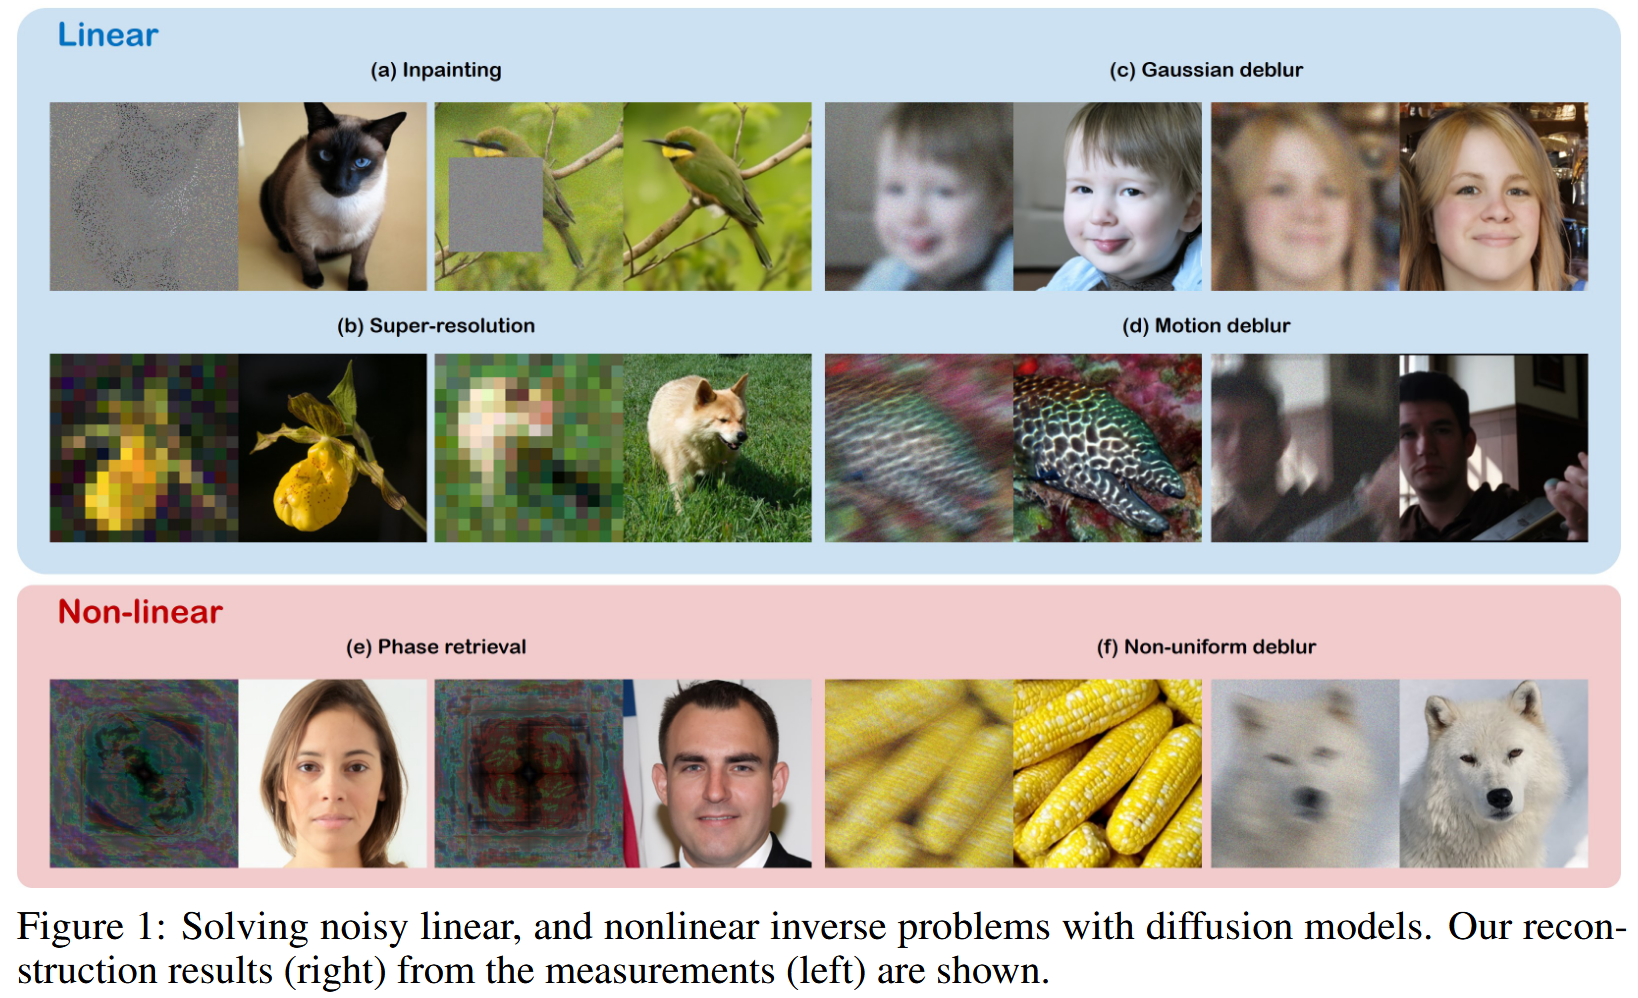


## 3. The Core Idea

This paper introduces **Diffusion Posterior Sampling (DPS)**, a general framework that combines the strength of diffusion models with classical Bayesian inference to solve **arbitrary noisy inverse problems**, without requiring retraining.

### 3.1 Goal

We want to sample from the **posterior distribution** $p(x|y)$, where:
- $x$ is the clean data we want to recover,
- $y$ is the observed measurement (e.g., blurred, compressed, masked image),
- and $y = A(x) + n$, where $A$ is a known forward operator and $n$ is noise.

### 3.2 Posterior sampling formulation

We apply Bayes' theorem:
```math
p(x|y) \propto p(y|x) \cdot p(x)
```
Here:
- $p(x)$ is the learned **prior** from the diffusion model.
- $p(y|x)$ comes from the **measurement model** $A$.

In the standard diffusion setup, the **reverse process** is modeled as:

```math
p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
```

But to condition this process on $y$, DPS adds a correction based on the measurement log-likelihood $\nabla_{x_t} \log p(y|x_t)$.

### 3.3 DPS Sampling Rule

At each step $t$, given a sample $x_t$, we update:
```math
x_t \leftarrow x_t + \eta_t \nabla_{x_t} \log p(y|x_t)
```
where $\eta_t$ is a step-size schedule.

This gradient is computed by defining a likelihood (based on the known forward model $A$):
```math
\log p(y|x) = -\| A(x) - y \|^2 / (2 \sigma^2)
```

So the final update is a **guided sampling**:
```math
x_t \leftarrow x_t + \eta_t \nabla_{x_t} \left[ -\| A(x_t) - y \|^2 \right]
```

This allows us to **plug in arbitrary forward models $A$**, such as:
- masking (for inpainting),
- blurring (for deblurring),
- downsampling (for super-resolution),
without retraining the diffusion model.



## References

[1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. *NeurIPS*  
[2] Song, Y., & Ermon, S. (2020). Score-based generative modeling through stochastic differential equations. *ICLR*  
[3] Song, J., Meng, C., & Ermon, S. (2023). Diffusion Posterior Sampling for General Noisy Inverse Problems. *ICLR*



###  Code Explanation — DPS 

This function implements **sampling using a pretrained diffusion model**, but with a key twist: it performs **posterior-guided inference** by incorporating measurement consistency.

> In contrast to standard diffusion models, which generate samples unconditionally (or conditionally on high-level information like text), **DPS (Diffusion Posterior Sampling)** adds a *gradient-based correction* at each denoising step to ensure that the output is consistent with an observed measurement $y = A(x) + n$.

This is particularly useful for **solving inverse problems**, where we don’t just want to generate “realistic” images — we want to generate images that **match what we observed** under a known forward model $A$.



### 🔧 Function Breakdown: `p_sample_loop()`

```python
def p_sample_loop(self, model, x_start, measurement, measurement_cond_fn, record, save_root):
```

This function starts from **pure noise** `x_start` and iteratively denoises it to obtain a final reconstruction `img`, guided by both the diffusion model and the observed measurement `y`.



#### 🔁 Main Loop: Reverse-Time Sampling

```python
pbar = tqdm(list(range(self.num_timesteps))[::-1])
for idx in pbar:
    time = torch.tensor([idx] * img.shape[0], device=device)
    img = img.requires_grad_()
```

- Loop through all timesteps from $T$ down to 1.
- Like in standard DDPM, the input at each step `x_t` requires gradients to allow gradient-based correction.



#### 🎯 1. Standard Diffusion Step

```python
out = self.p_sample(x=img, t=time, model=model)
```

This step computes the standard **reverse diffusion prediction**, producing:
- `out['sample']`: the denoised sample $x_{t-1}$
- `out['pred_xstart']`: estimated clean image $x_0$

> 🧠 This is identical to what a regular diffusion model does.



#### 📡 2. Add Measurement-Based Guidance (Key Difference!)

```python
noisy_measurement = self.q_sample(measurement, t=time)
img, distance = measurement_cond_fn(
    x_t=out['sample'],
    measurement=measurement,
    noisy_measurement=noisy_measurement,
    x_prev=img,
    x_0_hat=out['pred_xstart']
)
```

This is where **DPS differs from standard diffusion**:
- `measurement_cond_fn` uses the **forward model $A$** and the current output to compute a **gradient correction** that pulls `img` closer to satisfying $A(x) ≈ y$.
- The update may look like:
  ```python
  x_t ← x_t + η_t ∇ₓ log p(y | x)
  ```
- The `distance` tracks how far the current estimate is from matching the measurement.



#### 🧼 3. Detach and Proceed

```python
img = img.detach_()
```

Reset gradients before the next step. This makes sure each sampling step is independent.



#### 📊 4. Optional Visualization

```python
if record and idx % 100 == 0:
    # Save and show intermediate reconstruction
```

Every 100 steps, the current result is visualized and saved.



#### ✅ Return Final Result

```python
return img
```

This is the final output after all denoising and measurement-based corrections.



### 🧠 Summary of Differences from Standard Diffusion Models

| Aspect | Standard Diffusion | DPS (This Function) |
|--|--||
| Guidance | No / weak (classifier-free) | Strong physical consistency (via ∇ log p(y|x)) |
| Output goal | Any realistic image | Image that matches observation y |
| Usage | Generation (text2img, etc.) | Solving inverse problems |
| Gradient correction | None / optional | Always applied at every step |


In [ ]:
def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config


def main():
    sys.argv = ['']
    parser = argparse.ArgumentParser()

    parser.add_argument('--model_config', type=str, default='../../../../code/Inv/diffusion-posterior-sampling-main/configs/model_config.yaml', help='Path to the model configuration file')
    parser.add_argument('--diffusion_config', type=str, default='../../../../code/Inv/diffusion-posterior-sampling-main/configs/diffusion_config.yaml', help='Path to the diffusion configuration file')
    parser.add_argument('--task_config', type=str, default='../../../../code/Inv/diffusion-posterior-sampling-main/configs/super_resolution_config.yaml', help='Path to the task configuration file (default: {TASK-CONFIG})')
    parser.add_argument('--gpu', type=int, default=0, help='GPU index to use (default: 0)')
    parser.add_argument('--save_dir', type=str, default='../../../../code/Inv/diffusion-posterior-sampling-main/results', help='Directory to save results (default: ./results)')

    args = parser.parse_args()

    # logger
    logger = get_logger()
    
    # Device setting
    device_str = f"cuda:{args.gpu}" if torch.cuda.is_available() else 'cpu'
    logger.info(f"Device set to {device_str}.")
    device = torch.device(device_str)  
    
    # Load configurations
    model_config = load_yaml(args.model_config)
    diffusion_config = load_yaml(args.diffusion_config)
    task_config = load_yaml(args.task_config)
   
    #assert model_config['learn_sigma'] == diffusion_config['learn_sigma'], \
    #"learn_sigma must be the same for model and diffusion configuartion."
    
    # Load model
    model = create_model(**model_config)
    model = model.to(device)
    model.eval()

    # Prepare Operator and noise
    measure_config = task_config['measurement']
    operator = get_operator(device=device, **measure_config['operator'])
    noiser = get_noise(**measure_config['noise'])
    logger.info(f"Operation: {measure_config['operator']['name']} / Noise: {measure_config['noise']['name']}")

    # Prepare conditioning method
    cond_config = task_config['conditioning']
    cond_method = get_conditioning_method(cond_config['method'], operator, noiser, **cond_config['params'])
    measurement_cond_fn = cond_method.conditioning
    logger.info(f"Conditioning method : {task_config['conditioning']['method']}")
   
    # Load diffusion sampler
    sampler = create_sampler(**diffusion_config) 
    sample_fn = partial(sampler.p_sample_loop, model=model, measurement_cond_fn=measurement_cond_fn)
   
    # Working directory
    out_path = os.path.join(args.save_dir, measure_config['operator']['name'])
    os.makedirs(out_path, exist_ok=True)
    for img_dir in ['input', 'recon', 'progress', 'label']:
        os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)

    # Prepare dataloader
    data_config = task_config['data']
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = get_dataset(**data_config, transforms=transform)
    loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

    # Exception) In case of inpainting, we need to generate a mask 
    if measure_config['operator']['name'] == 'inpainting':
        mask_gen = mask_generator(
           **measure_config['mask_opt']
        )
        
    # Do Inference
    for i, ref_img in enumerate(loader):
        logger.info(f"Inference for image {i}")
        fname = str(i).zfill(5) + '.png'
        ref_img = ref_img.to(device)

        # Exception) In case of inpainging,
        if measure_config['operator'] ['name'] == 'inpainting':
            mask = mask_gen(ref_img)
            mask = mask[:, 0, :, :].unsqueeze(dim=0)
            measurement_cond_fn = partial(cond_method.conditioning, mask=mask)
            sample_fn = partial(sample_fn, measurement_cond_fn=measurement_cond_fn)

            # Forward measurement model (Ax + n)
            y = operator.forward(ref_img, mask=mask)
            y_n = noiser(y)

        else: 
            # Forward measurement model (Ax + n)
            y = operator.forward(ref_img)
            y_n = noiser(y)
         
        # Sampling
        x_start = torch.randn(ref_img.shape, device=device).requires_grad_()
        sample = sample_fn(x_start=x_start, measurement=y_n, record=True, save_root=out_path)

        plt.imsave(os.path.join(out_path, 'input', fname), clear_color(y_n))
        plt.imsave(os.path.join(out_path, 'label', fname), clear_color(ref_img))
        plt.imsave(os.path.join(out_path, 'recon', fname), clear_color(sample))

if __name__ == '__main__':
    main()
